[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cozek/hasoc_code/blob/master/notebooks/English/Task%20A%20-%20Outlier.ipynb)

# If working in colab, clone the repo

In [0]:
import os
import sys

try:
    __import__('google.colab')
    IN_COLAB = True
except:
    IN_COLAB = False

In [0]:
if IN_COLAB:
    os.system('rm -rf /content/hasoc_code/')
    os.system('git clone --recurse-submodules https://github.com/cozek/hasoc_code')
    sys.path.append('/content/hasoc_code/src')
else:
    sys.path.append('../../src')

# Import libraries

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import collections
from typing import Callable
import numpy as np
import pandas as pd
from tqdm import notebook
import importlib
import pprint
import nltk
import datetime
import os
from argparse import Namespace
import re
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [5]:
import utils.general as general_utils
import utils.data as data_utils
general_utils.set_seed_everywhere() #set the seed for reproducibility

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Set up the argspace/important_variables

In [0]:
args = Namespace(
    interactive = True, #set False for non interactive graphs
)

In [0]:
if not IN_COLAB:
    _prefix = '../../'
else : #for colab
    _prefix = '/content/hasoc_code/'
    #location of the train, dev and test csv
args.data_tsv = _prefix + 'data/english_dataset/english_dataset.tsv'
args.test_tsv = _prefix + 'data/english_dataset/hasoc2019_en_test-2919.tsv'

# Load the data tsv for Sub-task A
Sub-task A focus on Hate speech and Offensive language identification offered for English, German, Hindi. Sub-task A is coarse-grained binary classification in which participating system are required to classify tweets into two class, namely: Hate and Offensive (HOF) and Non- Hate and offensive (NOT).

- (NOT) Non Hate-Offensive - This post does not contain any Hate speech, offensive content.
- (HOF) Hate and Offensive - This post contains Hate, offensive, and profane content.

In our annotation, we label a post as HOF if it contains any form of non-acceptable language such as hate speech, aggression, profanity otherwise NOT.

### Load the train set

In [0]:
hasoc_data_df = pd.read_csv(args.data_tsv, sep='\t')
hasoc_data_df_task_a = hasoc_data_df[['text','task_1']]
hasoc_data_df_task_a.columns.values[1] = 'label'
hasoc_data_df_task_a = hasoc_data_df_task_a[hasoc_data_df_task_a.label != 'NONE']
del hasoc_data_df #free memory

### Train set Samples

In [9]:
hasoc_data_df_task_a.sample(5)

,text,label
3286,#Assange is not a #rapist https://t.co/M4sfW7...,NOT
2876,#GandiNaaliAbuse | Where an MP says that he wi...,HOF
2996,"Candle light silent protest in MYSORE, by Myso...",NOT
23,#ShameOnICC 1. ICC on Dhoni's gloves ...,HOF
1074,#ICC ...look at pak team...wht is going on.......,NOT


NOT    3591
HOF    2261
Name: label, dtype: int64


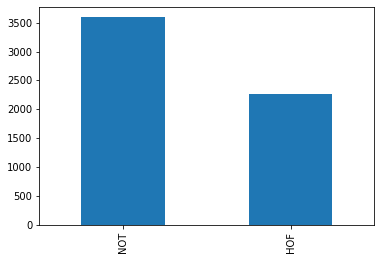

In [10]:
print(hasoc_data_df_task_a.label.value_counts())
hasoc_data_df_task_a.label.value_counts().plot(kind='bar')

### Split dataframe into train and validation

In [0]:
data_df = data_utils.Datasplitter.split_dataframe(hasoc_data_df_task_a, train_frac= 0.9, shuffle=True )

In [15]:
_data_df_train = data_df[data_df.split =='train'].label.value_counts()
_data_df_val = data_df[data_df.split =='val'].label.value_counts()

_val_fig = go.Figure(data=[
    go.Bar(name='Train', x=_data_df_train.index, y=_data_df_train.values),
    go.Bar(name='Val', x=_data_df_val.index, y=_data_df_val.values,)
])
_val_fig.update_layout(barmode='group')
_val_fig.show(renderer=(None if args.interactive else 'svg'))


## Can OneClassSVM detect hatespeech ?

We can use two appoaches
- _Approach 1_: Train OneClassSVM on HateSpeech and try to detect Harmless as novelty
- _Approach 2_: Train OneClassSVM on Harmless and try to detect HateSpeech as novelty

### One-Class Classification using SVM

The first order of affairs is to check how we can best fit an OneClassSVM on each class.
We need to find out
- The size of suitable of the n-grams to make TFIDF out of
- The type of tokenization we want
    - Word level
    - Char level

We also need to know
- Should we just use ngrams of just one size ?
- Should we combine multiple ngrams within a range ? Say combining ngrams of size 1 upto 5 ?


In [0]:
from sklearn.svm import OneClassSVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import sklearn.metrics

We define a function below that fits oneclass SVM each class. Its each class, it first fits the model on the train split and check it on the val split which contains both the classes. From this we can find out the model that can fit both seen and unseen examples, thereby testing both the above mentioned approaches.

In [0]:
def check_one_class_svm(
    data_df: pd.DataFrame,
    analyzer :str = 'word',
    ngram_max :int = 60,
):
    '''Runs OneClassSVM on each class in the given DataFrame
    
    Args:
        data_df (pd.DataFrame): Dataframe containing columns ['text','label','split']
        analyzer (str) : Analyzer To use with TfidfVectorizer  
        ngram_max (int) : Max ngram size to check
        
    Returns:
        _fig : Plotly subplots
        lbl_accs : Train,Val Accuracy with each ngram size for each class
    
    '''
    ngram_max = ngram_max #max n that we check
    labels = set(data_df.label)


    _fig = make_subplots(
        rows=len(labels), cols=1,
        subplot_titles= [f'Class : {l}' for l in labels],
        shared_yaxes=True,
        x_title='ngram size',
        y_title='Macro F1',
    )
    
    lbl_accs = { spl:{ lbl:{} for lbl in labels} for spl in set(data_df.split) } 

    
    for i,lbl in enumerate(labels, start = 1):
        
        #saving train accuracy for each n for each split
        ngram_acc = { spl:{} for spl in set(data_df.split) } 

        #check the n in ngram 
        for n in notebook.tqdm(range(1,ngram_max+1), total = ngram_max):
            
            tfidf_vectorizer = TfidfVectorizer(ngram_range=(n,n), analyzer = analyzer)
            clf = OneClassSVM(gamma='auto')

            for spl in ['train','val']:
                
                #Get the samples with the corresponding label from the DF
                hate_text_df =\
                    data_df[ (data_df.split == spl) & (data_df.label == lbl) ]
                
                true_labels = [1 for i in range(len(hate_text_df))]

                if spl == 'train':
                    hate_tfidf = tfidf_vectorizer.fit_transform(hate_text_df.text)
                    clf.fit(hate_tfidf)

                elif spl == 'val':
                    val_df = data_df[ (data_df.split == spl) ].copy()
                    val_df = val_df.assign(label_ints = 1)
                    val_df.loc[val_df['label']=='NOT',['label_ints']] = -1
                    true_labels = val_df.label_ints
                    hate_tfidf = tfidf_vectorizer.transform(val_df.text)
                

                preds = clf.predict(hate_tfidf)
                acc = sklearn.metrics.f1_score(
                    y_true = true_labels,
                    y_pred = preds,
                    average = 'macro' 
                )
                
                ngram_acc[spl][n] = acc
                lbl_accs[spl][lbl][n] = acc
                    

        for spl in ['train','val']: 
            subfig = go.Scatter(
                    x = list(ngram_acc[spl].keys()),
                    y = list(ngram_acc[spl].values()),
                    mode = "lines+markers",
                    name=f'{lbl}-{spl}',
                )

            _fig.append_trace(subfig, row = i, col=1)


        

        
    _fig.update_layout(
            title = f"OneClass SVM for each class using {analyzer} n-grams",
        )
    
    return _fig, lbl_accs 

    

### Training OneClass SVM for each class with word ngrams

In [95]:
word_ngram_fig, word_ngram_lbl_accs = check_one_class_svm(
    data_df= data_df,
    analyzer = 'word',
    ngram_max  = 60,
)

In [96]:
word_ngram_fig.show(renderer=(None if args.interactive else 'svg')) #remove renderer argument

for spl in ['train', 'val']:
    for lbl in set(data_df.label):
        ngram_dict = word_ngram_lbl_accs[spl][lbl]
        best_n = max(list(ngram_dict.items()), key = lambda x: x[1])    
        print(f'{spl} : {lbl}  -> Best Acc: {best_n[1]} with n: {best_n[0]}')

train : NOT  -> Best Acc: 0.4997678377960068 with n: 59
train : HOF  -> Best Acc: 0.4992618110236221 with n: 59
val : NOT  -> Best Acc: 0.486850058117009 with n: 3
val : HOF  -> Best Acc: 0.49417312703438876 with n: 1


### Training OneClass SVM for each class with character ngrams

In [97]:
char_ngram_fig, char_ngram_lbl_accs = check_one_class_svm(
    data_df= data_df,
    analyzer = 'char',
    ngram_max  = 20,
)

In [98]:
char_ngram_fig.show(renderer=(None if args.interactive else 'svg')) #remove renderer argument


for spl in ['train', 'val']:
    for lbl in set(data_df.label):
        ngram_dict = char_ngram_lbl_accs[spl][lbl]
        best_n = max(list(ngram_dict.items()), key = lambda x: x[1])    
        print(f'{spl} : {lbl}  -> Best Acc: {best_n[1]} with n: {best_n[0]}')

train : NOT  -> Best Acc: 1.0 with n: 18
train : HOF  -> Best Acc: 1.0 with n: 11
val : NOT  -> Best Acc: 0.5695623854096306 with n: 20
val : HOF  -> Best Acc: 0.5800060457969116 with n: 18


### Training OneClass SVM for each class with character_word_bounded ngrams

In [99]:
charwb_ngram_fig, charwb_ngram_lbl_accs = check_one_class_svm(
    data_df= data_df,
    analyzer = 'char_wb',
    ngram_max  = 30,
)

In [101]:
charwb_ngram_fig.show(renderer=(None if args.interactive else 'svg')) #remove renderer argument


for spl in ['train', 'val']:
    for lbl in set(data_df.label):
        ngram_dict = charwb_ngram_lbl_accs[spl][lbl]
        best_n = max(list(ngram_dict.items()), key = lambda x: x[1])    
        print(f'{spl} : {lbl}  -> Best Acc: {best_n[1]} with n: {best_n[0]}')

train : NOT  -> Best Acc: 0.35873015873015873 with n: 4
train : HOF  -> Best Acc: 0.493529118964659 with n: 10
val : NOT  -> Best Acc: 0.5400411225933938 with n: 1
val : HOF  -> Best Acc: 0.557769215762778 with n: 27
